In [71]:
import pandas as pd
import numpy as np
import matplotlib
import sklearn as skl
import matplotlib.pyplot as plt
import seaborn as sns 
from tqdm.notebook import tqdm_notebook
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

In [72]:
train = pd.read_csv('/content/drive/MyDrive/Competitions/IndabaX Ghana AutoInland Vehicle Insurance Claim/IndabaX_Train.csv')
test = pd.read_csv('/content/drive/MyDrive/Competitions/IndabaX Ghana AutoInland Vehicle Insurance Claim/IndabaX_Test.csv')
SS = pd.read_csv('/content/drive/MyDrive/Competitions/IndabaX Ghana AutoInland Vehicle Insurance Claim/SampleSubmission.csv')

In [73]:
train.head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target
0,ID_0040R73,2010-05-14,2011-05-13,Male,30,2010-05-14,1,Saloon,Black,TOYOTA,NaN,NaN,Car Classic,0
1,ID_0046BNK,2010-11-29,2011-11-28,Female,79,2010-11-29,1,JEEP,Grey,TOYOTA,NaN,NaN,Car Classic,1
2,ID_005QMC3,2010-03-21,2011-03-20,Male,43,2010-03-21,1,Saloon,Red,TOYOTA,NaN,NaN,Car Classic,0
3,ID_0079OHW,2010-08-21,2011-08-20,Male,2,2010-08-21,1,NaN,NaN,NaN,NaN,NaN,CarSafe,0
4,ID_00BRP63,2010-08-29,2010-12-31,Entity,20,2010-08-29,3,NaN,NaN,NaN,Lagos,Lagos,Muuve,1


In [74]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12079 entries, 0 to 12078
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   ID                      12079 non-null  object
 1   Policy Start Date       12079 non-null  object
 2   Policy End Date         12079 non-null  object
 3   Gender                  11720 non-null  object
 4   Age                     12079 non-null  int64 
 5   First Transaction Date  12079 non-null  object
 6   No_Pol                  12079 non-null  int64 
 7   Car_Category            8341 non-null   object
 8   Subject_Car_Colour      5117 non-null   object
 9   Subject_Car_Make        9603 non-null   object
 10  LGA_Name                5603 non-null   object
 11  State                   5591 non-null   object
 12  ProductName             12079 non-null  object
 13  target                  12079 non-null  int64 
dtypes: int64(3), object(11)
memory usage: 1.3+ MB


In [75]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1202 entries, 0 to 1201
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   ID                      1202 non-null   object
 1   Policy Start Date       1202 non-null   object
 2   Policy End Date         1202 non-null   object
 3   Gender                  1161 non-null   object
 4   Age                     1202 non-null   int64 
 5   First Transaction Date  1202 non-null   object
 6   No_Pol                  1202 non-null   int64 
 7   Car_Category            830 non-null    object
 8   Subject_Car_Colour      505 non-null    object
 9   Subject_Car_Make        954 non-null    object
 10  LGA_Name                546 non-null    object
 11  State                   546 non-null    object
 12  ProductName             1202 non-null   object
dtypes: int64(2), object(11)
memory usage: 122.2+ KB


In [76]:
for col in train.columns:
  print(f'The number of unique values of {col}: {len(train[col].unique())}')

The number of unique values of ID: 12079
The number of unique values of Policy Start Date: 376
The number of unique values of Policy End Date: 372
The number of unique values of Gender: 8
The number of unique values of Age: 110
The number of unique values of First Transaction Date: 376
The number of unique values of No_Pol: 8
The number of unique values of Car_Category: 17
The number of unique values of Subject_Car_Colour: 46
The number of unique values of Subject_Car_Make: 75
The number of unique values of LGA_Name: 259
The number of unique values of State: 112
The number of unique values of ProductName: 9
The number of unique values of target: 2


In [77]:
train[train['First Transaction Date']== train['Policy Start Date']].shape[0]

12079

The First transaction date ist the same Policy start date.

In [78]:
# Combine train and test set
ntrain = train.shape[0] # to be used to split train and test set from the combined dataframe

all_data = pd.concat((train, test)).reset_index(drop=True)

In [79]:
all_data.drop(['First Transaction Date'],axis=1,inplace=True)

In [80]:
all_data['Subject_Car_Colour'].fillna('Unknown',inplace=True)
all_data['LGA_Name'].fillna('Unknown',inplace= True)
all_data['Car_Category'].fillna('Unknown',inplace = True)
all_data['Subject_Car_Make'].fillna('Unknown', inplace = True)
all_data['State'].fillna('Unknown', inplace = True)
all_data['Gender'].fillna('Unknown', inplace = True)

In [81]:
all_data['Gender'].value_counts()

Male            8356
Female          3679
Unknown          400
Entity           300
Joint Gender     238
NOT STATED       190
NO GENDER         76
SEX               42
Name: Gender, dtype: int64

In [82]:
all_data['Gender'] = all_data['Gender'].replace({'Entity': 'Other',
                                                'Joint Gender':'Other',
                                                'NOT STATED':'Other',
                                                'NO GENDER': 'Other',
                                                'SEX':'Other'})
all_data['Gender'].value_counts()

Male       8356
Female     3679
Other       846
Unknown     400
Name: Gender, dtype: int64

In [83]:
date_cols = [col for col in all_data.columns if 'Date' in col]
num_cols = ['Age', 'No_Pol']
cat_cols = [col for col in all_data.columns if col not in date_cols+num_cols+['ID', 'target']]

for col in all_data.columns:
  if col in date_cols:
    all_data[col] = pd.to_datetime(all_data[col])
  elif col in cat_cols:
    all_data[col] = all_data[col].astype('category')

# Confirm whether the changes have been applied successfully
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13281 entries, 0 to 13280
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   ID                  13281 non-null  object        
 1   Policy Start Date   13281 non-null  datetime64[ns]
 2   Policy End Date     13281 non-null  datetime64[ns]
 3   Gender              13281 non-null  category      
 4   Age                 13281 non-null  int64         
 5   No_Pol              13281 non-null  int64         
 6   Car_Category        13281 non-null  category      
 7   Subject_Car_Colour  13281 non-null  category      
 8   Subject_Car_Make    13281 non-null  category      
 9   LGA_Name            13281 non-null  category      
 10  State               13281 non-null  category      
 11  ProductName         13281 non-null  category      
 12  target              12079 non-null  float64       
dtypes: category(7), datetime64[ns](2), float64(1),

In [84]:
# Fill in missing values
# For cat cols and date cols fill in with mode and for num cols fill in with 9999
for col in all_data.columns:
  if col in date_cols+cat_cols:
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])
  elif col in num_cols:
    all_data[col] = all_data[col].fillna(all_data[col].fillna(round(all_data[col].mean())))

# Confirm that there aren't any missing values
all_data[all_data.columns.difference(['target'])].isna().sum()

Age                   0
Car_Category          0
Gender                0
ID                    0
LGA_Name              0
No_Pol                0
Policy End Date       0
Policy Start Date     0
ProductName           0
State                 0
Subject_Car_Colour    0
Subject_Car_Make      0
dtype: int64

In [85]:
for col in date_cols:
  for date_feature in ['day','dayofweek','dayofyear','year', 'month']:
    all_data[col+' '+date_feature] = getattr(all_data[col].dt, date_feature)

all_data.head()

,ID,Policy Start Date,Policy End Date,Gender,Age,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target,Policy Start Date day,Policy Start Date dayofweek,Policy Start Date dayofyear,Policy Start Date year,Policy Start Date month,Policy End Date day,Policy End Date dayofweek,Policy End Date dayofyear,Policy End Date year,Policy End Date month
0,ID_0040R73,2010-05-14,2011-05-13,Male,30,1,Saloon,Black,TOYOTA,Unknown,Unknown,Car Classic,0.0,14,4,134,2010,5,13,4,133,2011,5
1,ID_0046BNK,2010-11-29,2011-11-28,Female,79,1,JEEP,Grey,TOYOTA,Unknown,Unknown,Car Classic,1.0,29,0,333,2010,11,28,0,332,2011,11
2,ID_005QMC3,2010-03-21,2011-03-20,Male,43,1,Saloon,Red,TOYOTA,Unknown,Unknown,Car Classic,0.0,21,6,80,2010,3,20,6,79,2011,3
3,ID_0079OHW,2010-08-21,2011-08-20,Male,2,1,Unknown,Unknown,Unknown,Unknown,Unknown,CarSafe,0.0,21,5,233,2010,8,20,5,232,2011,8
4,ID_00BRP63,2010-08-29,2010-12-31,Other,20,3,Unknown,Unknown,Unknown,Lagos,Lagos,Muuve,1.0,29,6,241,2010,8,31,4,365,2010,12


In [86]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
for col in cat_cols:
  all_data[col] = encoder.fit_transform(all_data[col])

In [87]:
# Separate train and test data from the combined dataframe
train_df = all_data[:ntrain]
test_df = all_data[ntrain:]

# Check the shapes of the split dataset
train_df.shape, test_df.shape

((12079, 23), (1202, 23))

In [88]:
# Select main columns to be used in training
features = train_df.columns.difference(['ID','target','Policy End Date','Policy Start Date'])

X = train_df[features]
y = train_df.target

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1, random_state=123)

In [89]:
train_df[train_df['target']==0].shape[0]/train_df.shape[0]

0.8795430085271959

In [90]:

w = 0.2
model = LGBMClassifier(n_estimators=800,
                       num_leaves=15,
                       class_weight={0:w, 1:1-w})

# Create a StratifiedKFold object
str_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

fold_metrics = []

for train_index, test_index in str_kf.split(X,y):
  cv_train, cv_test = X.iloc[train_index], X.iloc[test_index]
  y_train_cv, y_test_cv = y[train_index], y[test_index]
# Train a model
  model.fit(cv_train,y_train_cv)
# Make predictions
  predictions = model.predict(cv_test)
# Calculate the metric
  metric = f1_score(y_test_cv, predictions)
  fold_metrics.append(metric)

np.mean(fold_metrics), np.std(fold_metrics)

(0.3341078100018775, 0.021848273563596622)

In [91]:
Local_val = round(np.mean(fold_metrics),4)

[Text(0, 0, 'Age'),
 Text(0, 0, 'Policy End Date dayofyear'),
 Text(0, 0, 'Policy Start Date dayofyear'),
 Text(0, 0, 'LGA_Name'),
 Text(0, 0, 'Policy Start Date day'),
 Text(0, 0, 'Subject_Car_Make'),
 Text(0, 0, 'Policy End Date day'),
 Text(0, 0, 'Subject_Car_Colour'),
 Text(0, 0, 'State'),
 Text(0, 0, 'Policy End Date dayofweek'),
 Text(0, 0, 'ProductName'),
 Text(0, 0, 'Policy Start Date dayofweek'),
 Text(0, 0, 'Car_Category'),
 Text(0, 0, 'Gender'),
 Text(0, 0, 'No_Pol'),
 Text(0, 0, 'Policy Start Date month'),
 Text(0, 0, 'Policy End Date month'),
 Text(0, 0, 'Policy End Date year'),
 Text(0, 0, 'Policy Start Date year')]

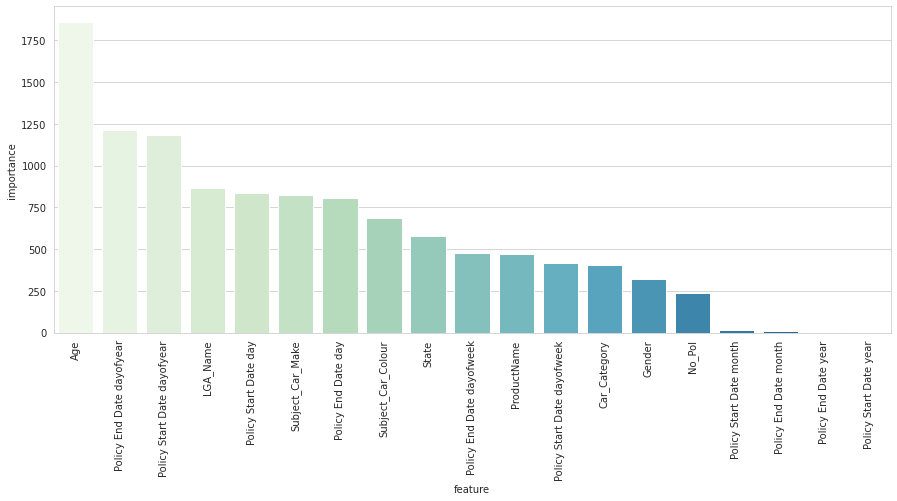

In [92]:
importance = model.feature_importances_

importance_df = pd.DataFrame({'feature':X_train.columns,
'importance':importance})
importance_df.sort_values('importance',ascending = False,inplace=True)

f, ax = plt.subplots(figsize = (15,6))
ax = sns.barplot(data=importance_df,x='feature', y = 'importance',
palette="GnBu")
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

In [93]:
# Make prediction on the test set
test_df = test_df[features]
  
predictions = model.predict(test_df)

# Create a submission file
sub_file = SS.copy()
sub_file.target = predictions

In [94]:
# Create a csv file and upload to zindi 
sub_file.to_csv(f'IndabaX_Ghana_Sub({Local_val}).csv', index = False)